In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm.auto import tqdm

In [ ]:
import keras
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

Using TensorFlow backend.


In [ ]:
IMAGE_LIB = '/content/drive/My Drive/緯育醫學影像/Day6/annotation_tools/img/*.png'
MASK_LIB = '/content/drive/My Drive/緯育醫學影像/Day6/annotation_tools/mask/*.png'
IMG_SIZE = 256
SEED = 5566
NUM_CLASSES = 3

# Data

In [ ]:
img_paths = sorted(glob(IMAGE_LIB))
mask_paths = sorted(glob(MASK_LIB))

x_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE))
y_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE, NUM_CLASSES))

for i, path in enumerate(tqdm(img_paths)):
    # read input image
    img = cv2.imread(path)[:,:,0] # get channel 0 since it's a gray scale image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.
    x_data[i] = img
    filename_img = os.path.split(path)[1] # filename_img: seg1.png
    filename = filename_img.split('.')[0] # filename: seg1
    # read mask image
    for j in range(NUM_CLASSES):
        mask = cv2.imread(os.path.join('/content/drive/My Drive/緯育醫學影像/Day6/annotation_tools/mask', f'{filename}_mask_{j}.png'))[:,:,0] # seg1_mask_0.png, seg1_mask_1.png, seg1_mask_2.png
        mask = mask / 255.
        mask[mask>=0.5] = 1.
        mask[mask<0.5] = 0
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        y_data[i, :, :, j] = mask


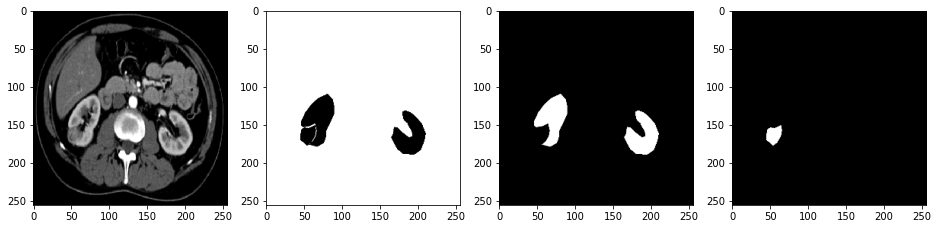

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (16,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0, :, :, 0], cmap='gray')
ax[2].imshow(y_data[0, :, :, 1], cmap='gray')
ax[3].imshow(y_data[0, :, :, 2], cmap='gray')
plt.show()

In [ ]:
x_data.shape, y_data.shape

((1, 256, 256), (1, 256, 256, 3))

In [ ]:
x_data = np.expand_dims(x_data, axis=-1)
x_data.shape, y_data.shape

((1, 256, 256, 1), (1, 256, 256, 3))

# Model

In [ ]:
# Unet with Conv2DTranspose
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
l = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c1)
l = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
c3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
c4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4), c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l), c2], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l), c1], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
output_layer = Conv2D(filters=NUM_CLASSES, kernel_size=(1,1), activation='softmax')(l)
                                                         
model = Model(input_layer, output_layer)

In [ ]:
model.compile(optimizer=Adam(), loss=keras.losses.categorical_crossentropy)

In [ ]:
hist = model.fit(x_data, y_data, batch_size=1,
                epochs=600, verbose=2)

In [ ]:
model.save('multi-class-seg.h5')

## Display

In [ ]:
model = load_model('/content/drive/My Drive/緯育醫學影像/Day6/multi-class-seg.h5')

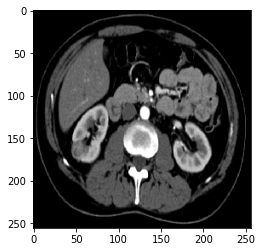

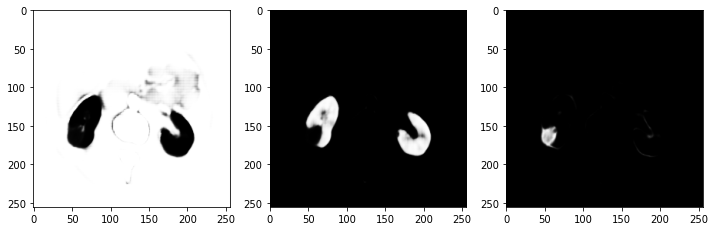

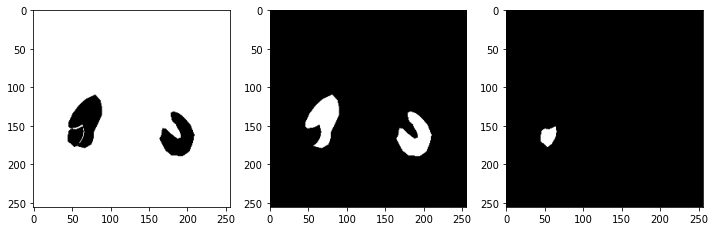

In [ ]:
img_input = x_data[0:1]
y_pred = model.predict(img_input)

# input img
plt.imshow(img_input[0, :, :, 0], cmap='gray')
plt.show()

# pred
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(NUM_CLASSES):
    pred_mask = y_pred[0, :, :, i]
    ax[i].imshow(pred_mask, cmap='gray')  
plt.show()

# Truth
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(NUM_CLASSES):
    y_truth = y_data[0, :, :, i]
    ax[i].imshow(y_truth, cmap='gray')  
plt.show()